### Обязательная часть
Вам необходимо провести базовый EDA выбранного набора данных.  

Требования к анализу:  
построить не менее 4 визуализаций различных видов;  
каждая визуализация должным образом оформлена и читается даже в отрыве от контекста;  
по каждой визуализации необходимо написать вывод (какую гипотезу на ее основе можно выдвинуть?). 

Откуда брать данные?    
Можете взять свои рабочие данные, либо найти открытые данные (например, на kaggle.com) по интересующей вас   предметной области (тогда не забудьте их выложить на github вместе с ноутбуком). Если идей нет, можете взять один из перечисленных ниже:  
данные приложений из Google Play;  
данные о видео из трендов YouTube;  
данные об уровне счастья в разных странах;  
данные по фильмам и сериалам Netflix  


In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 13,6
import seaborn as sns

In [410]:
df = pd.read_csv('COVID-19_Case_Surveillance_Public_Use_Data.csv', low_memory=False)

In [237]:
df.columns

Index(['cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'current_status', 'sex',
       'age_group', 'Race and ethnicity (combined)', 'hosp_yn', 'icu_yn',
       'death_yn', 'medcond_yn'],
      dtype='object')

In [238]:
#посмотрим на df. cdc_report_dt и pos_spec_dt нужно преобразовать в date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
cdc_report_dt                    object
pos_spec_dt                      object
onset_dt                         object
current_status                   object
sex                              object
age_group                        object
Race and ethnicity (combined)    object
hosp_yn                          object
icu_yn                           object
death_yn                         object
medcond_yn                       object
dtypes: object(11)
memory usage: 705.4+ MB


In [239]:
df.describe()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
count,8405079,2870789,4395957,8405079,8405061,8404990,8405072,8405079,8405079,8405079,8405079
unique,321,313,338,2,5,10,9,4,4,4,4
top,2020/06/24,2020/11/09,2020/11/02,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Missing,No,Missing
freq,155857,50595,49527,7910118,4340898,1635264,2781176,3502556,6178281,3690813,6063390


In [413]:
#преобразуем в нужные форматы
df[['cdc_report_dt','pos_spec_dt', 'onset_dt']] = df[['cdc_report_dt','pos_spec_dt', 'onset_dt']].apply(pd.to_datetime, format='%Y-%m-%d')

In [414]:
#для некоторых визуализаций скорее всего понадобиться месячные данные
df['pos_spec_month'] = df['cdc_report_dt'].dt.month.replace(np.nan).astype('Int64')

In [415]:
#посмотрим на df. Некоторые данные нужно преобразовать в int
#остальные можно оставить в str
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 12 columns):
cdc_report_dt                    datetime64[ns]
pos_spec_dt                      datetime64[ns]
onset_dt                         datetime64[ns]
current_status                   object
sex                              object
age_group                        object
Race and ethnicity (combined)    object
hosp_yn                          object
icu_yn                           object
death_yn                         object
medcond_yn                       object
pos_spec_month                   Int64
dtypes: Int64(1), datetime64[ns](3), object(8)
memory usage: 777.5+ MB


Text(0.5, 0, 'Количество заболевших')

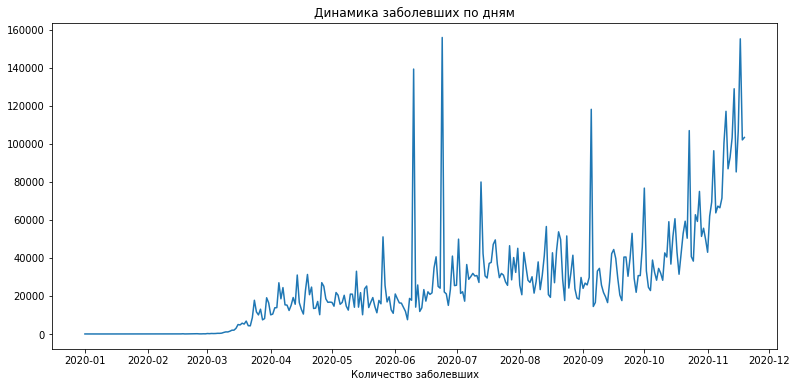

In [244]:
#сгрупируем по дням и посмотрим на прирост заболевших 
date_of_patients = df[['cdc_report_dt', 'sex']].groupby('cdc_report_dt').count()
plt.plot(date_of_patients.index, date_of_patients.sex)
plt.title('Динамика заболевших по дням')
plt.xlabel('День')
plt.xlabel('Количество заболевших')
#на самом деле не очень удачная визуализация, так как слишком много дат
#но в целом можно понять, что кол-во заболеваний в день увеличивается от начала к концу года
#так же видно, что имются выбросы в некоторых днях, возможно это связано с тем, 
#что в эти даты идут накопительные итоги за другие дни по теститрованию пациентов

In [245]:
#построем распределение по приросту заболеваний в неделю относительно каждой группы возраста

In [246]:
df['week_number'] = df['cdc_report_dt'].dt.week

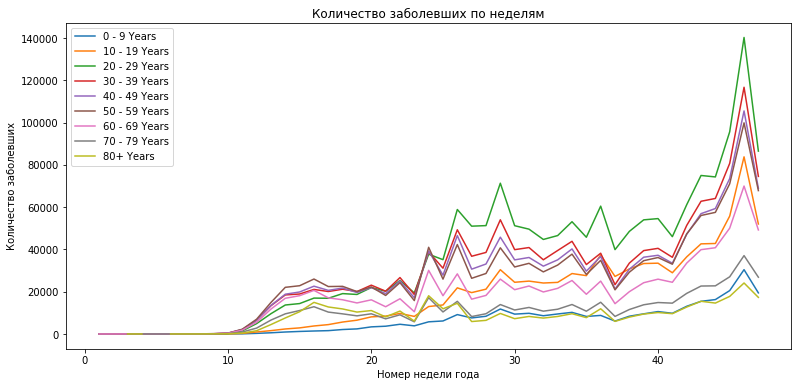

In [248]:
df_count_age = df[['week_number', 'age_group', 'sex']].groupby(['week_number', 'age_group']).count().reset_index()
table = pd.pivot_table(df_count_age, values='sex', index='week_number', columns=['age_group'], aggfunc=np.sum)
for group in [x for x in table.columns if 'Years' in x]:
    plt.plot(table.index, table[group])
    plt.title('Количество заболевших по неделям')
    plt.xlabel('Номер недели года')
    plt.ylabel('Количество заболевших') 
    plt.legend(table)
#Из графика видно, что больше все заболевших в возрастной группе 20-29 лет , а меньше всего в группах
#80+, 0-9, 70-79
#можно сделать 2 противоречивых вывода: такое распределение проиходит из-за того, что просто в этих группах 
#большая численность людей, либо в этих группах люди меньнее или более социально-активные, что влияет на заражение

In [363]:
#построим распределение по количеству летальных исходов в группах 
#в процентом соотношении к числу людей в этой группе
#в данном случае это будет более точный анализ, так как количество людей в группах разное
#и если смотреть абсолютное количество смертей к группе, скорее всего можно увидеть, что
#чем больше группа, тем больше смертей
count_death = df[['age_group', 'death_yn', 'sex']].groupby(['age_group', 'death_yn']).count().reset_index()
count_death = pd.pivot_table(count_death, values='sex', index='age_group',  columns='death_yn', aggfunc=np.sum).reset_index()
#общее кол-во людей в группе
count_group = df[['age_group', 'sex']].groupby(['age_group']).count()
per_death_group = count_death.merge(count_group, how='left', right_on = 'age_group', left_on='age_group')
#посчитаем процент умерших и выживших к общейму количеству людей в группе
per_death_group['per_death_yes'] = round(per_death_group['Yes'] / per_death_group['sex'] * 100, 1)
per_death_group['per_death_no'] = round(per_death_group['No'] / per_death_group['sex'] * 100, 1)
#per_death_group = per_death_group.drop(['sex_x', 'sex_y'], axis=1)

In [369]:
per_death_group

,age_group,Missing,No,Unknown,Yes,sex,per_death_yes,per_death_no
0,0 - 9 Years,124317,146683,27969,71,299040,0.0,49.1
1,10 - 19 Years,355363,393562,92390,135,841450,0.0,46.8
2,20 - 29 Years,703813,727826,202775,850,1635264,0.1,44.5
3,30 - 39 Years,583855,614807,171700,2261,1372623,0.2,44.8
4,40 - 49 Years,532137,568016,161800,5397,1267350,0.4,44.8
5,50 - 59 Years,508919,541606,162995,13973,1227493,1.1,44.1
6,60 - 69 Years,345627,371788,115888,29957,863260,3.5,43.1
7,70 - 79 Years,180951,196309,60979,45450,483689,9.4,40.6
8,80+ Years,125387,125844,46177,85461,382869,22.3,32.9
9,Unknown,26521,4324,1092,15,31952,0.0,13.5


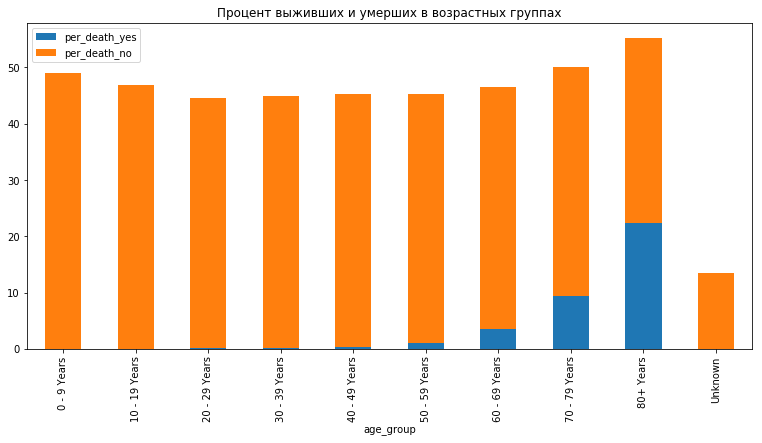

In [403]:
per_death_group[['age_group', 'per_death_yes', 'per_death_no']].groupby(['age_group']).sum().plot(kind='bar',
                 title='Процент выживших и умерших в возрастных группах', stacked=True)
#из гистограммы видно, что на группу 80+ приходится самый большой процент смертей
#в целом это закономерно, так как как чем выше возраст, тем сложнее человек потдается лечению

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1bb8bb278>],
      dtype=object)

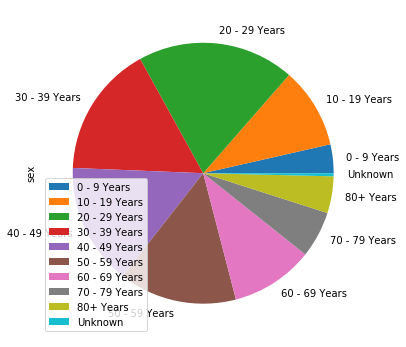

In [408]:
#посмотрим, как происходит распределение заболевших внутри групп 
count_group = df[['age_group', 'sex']].groupby(['age_group']).count()
count_group.plot(kind='pie', subplots=True)
#в целом не особо полезная диаграмма, так не очень понятно, в какой группе больше заболевших

### Дополнительная часть (необязательная)
построить дополнительно не менее 2 визуализаций (итого не менее 6);
в работе должны присутствовать следующие визуализации: boxplot, heatmap, scatter plot matrix;

In [411]:
df.describe()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
count,8405079,2870789,4395957,8405079,8405061,8404990,8405072,8405079,8405079,8405079,8405079
unique,321,313,338,2,5,10,9,4,4,4,4
top,2020/06/24,2020/11/09,2020/11/02,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Missing,No,Missing
freq,155857,50595,49527,7910118,4340898,1635264,2781176,3502556,6178281,3690813,6063390


In [ ]:
#Посмотрим, как зависит госпитализация и выживание заболевших в возрастных группах

In [536]:
death = df.loc[(df['hosp_yn'] == 'No') | (df['hosp_yn'] == 'Yes')][['cdc_report_dt', 'age_group', 'hosp_yn']].groupby(['cdc_report_dt', 'age_group']).count().reset_index()
hosp = df.loc[(df['death_yn'] == 'No') | (df['death_yn'] == 'Yes')][['cdc_report_dt', 'age_group', 'death_yn']].groupby(['cdc_report_dt', 'age_group']).count().reset_index()

In [537]:
hosp_death = death.merge(hosp, how='left', left_on=['cdc_report_dt', 'age_group'], right_on=['cdc_report_dt', 'age_group'])

In [544]:
hosp_death.head()

,cdc_report_dt,age_group,hosp_yn,death_yn
0,2020-01-01,20 - 29 Years,1,1.0
1,2020-01-01,30 - 39 Years,2,3.0
2,2020-01-01,40 - 49 Years,1,1.0
3,2020-01-01,50 - 59 Years,1,2.0
4,2020-01-01,60 - 69 Years,2,2.0


Text(0.5, 1.0, 'Зависимость госпитолизаций')

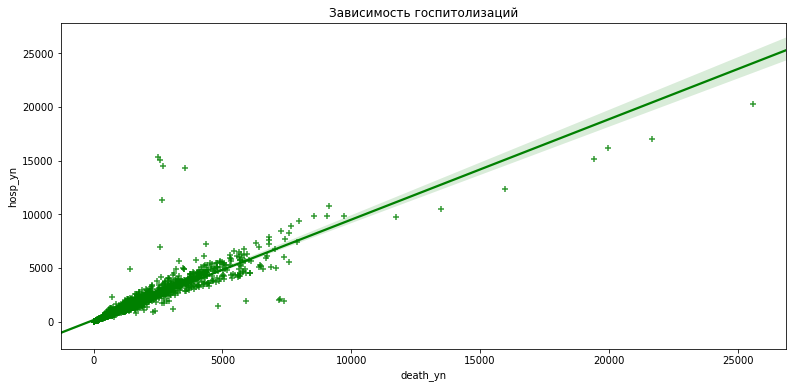

In [545]:
#есть гипотеза: чем больше госпитализаций, тем меньше смертей
#в данном случае гипотеза не подтвердилась, в данном случае мы видим, что существует прямая зависимоть, 
#пропорциально увеличивается число госпитализаций, так и летальных исходов, так как в целом наблюдается рост заболеваний
ax = sns.regplot(data=hosp_death, x='death_yn', y='hosp_yn', color='green', marker='+')
ax.set_title('Зависимость госпитолизаций')

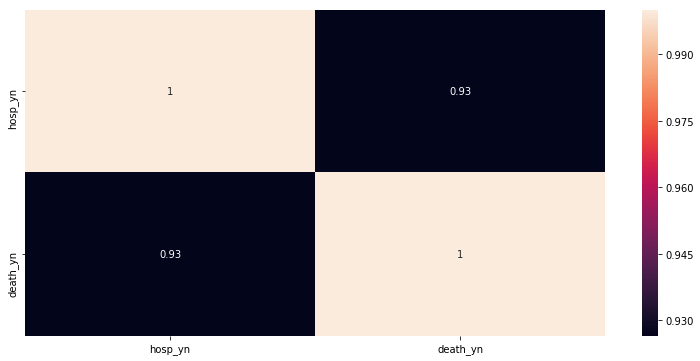

In [555]:
#Наша гипотеза опровергается практически прямой зависимостью между госпитализациями и летальными исходами
sns.heatmap(hosp_death.corr(), annot=True)